# Predicting Infection Risk from CPT, Microbiology, and Lab Events
This notebook builds a machine learning and deep learning pipeline to predict infection risk in ICU patients using MIMIC-III data.

In [3]:
# Step 1: Load Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Step 2: Load Data (replace paths as needed)
cptevents = pd.read_csv('CPTEVENTS.csv')
microbio = pd.read_csv('MICROBIOLOGYEVENTS.csv')
labevents = pd.read_csv('LABEVENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')

/var/folders/4v/p_ltq8v135ggx_jn7q66xr680000gn/T/ipykernel_40232/4065733134.py:2: DtypeWarning: Columns (4,5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cptevents = pd.read_csv('CPTEVENTS.csv')


In [5]:
# Step 3: Define Target Variable (Infection Risk)
infected_hadm_ids = microbio[microbio['ORG_NAME'].notnull()]['HADM_ID'].unique()
admissions['infection_label'] = admissions['HADM_ID'].isin(infected_hadm_ids).astype(int)

In [6]:
# Step 4: Feature Engineering
# CPT Code Features
cpt_features = cptevents.groupby(['HADM_ID', 'CPT_CD']).size().unstack(fill_value=0)

In [7]:
# Lab Event Features
important_items = [50811, 50912, 50931]  # WBC, Glucose, Lactate
lab_filtered = labevents[labevents['ITEMID'].isin(important_items)]
lab_agg = lab_filtered.groupby(['HADM_ID', 'ITEMID'])['VALUENUM'].agg(['mean', 'min', 'max']).unstack()
lab_agg.columns = ['{}_{}'.format(item, stat) for item, stat in lab_agg.columns]
lab_agg = lab_agg.fillna(0)

In [8]:
# Step 5: Combine Features and Labels
features = cpt_features.join(lab_agg, how='outer').fillna(0)
features = features.join(admissions.set_index('HADM_ID')['infection_label'], how='inner')
features.columns = features.columns.astype(str)

In [9]:
# Step 6: ML Modeling
X = features.drop(columns=['infection_label'])
y = features['infection_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.73      0.91      0.81      6270
           1       0.78      0.47      0.59      4065

    accuracy                           0.74     10335
   macro avg       0.75      0.69      0.70     10335
weighted avg       0.75      0.74      0.72     10335



/Users/devanshkochar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      6270
           1       0.74      0.57      0.64      4065

    accuracy                           0.75     10335
   macro avg       0.75      0.72      0.73     10335
weighted avg       0.75      0.75      0.74     10335



## LSTM Model Preparation

In [13]:
# Step 7: Prepare Lab Sequences for LSTM
def create_lab_sequence(hadm_id, item_ids, max_len=24):
    patient_data = lab_filtered[lab_filtered['HADM_ID'] == hadm_id]
    seq = []
    for item in item_ids:
        values = patient_data[patient_data['ITEMID'] == item].sort_values('CHARTTIME')['VALUENUM'].values
        padded = np.pad(values[:max_len], (0, max(0, max_len - len(values))), 'constant', constant_values=0)
        seq.append(padded)
    return np.stack(seq, axis=1)  # shape: (max_len, num_features)

hadm_ids = admissions['HADM_ID'].unique()
X_seq = []
y_seq = []
for hid in hadm_ids:
    if hid in admissions['HADM_ID'].values:
        try:
            seq = create_lab_sequence(hid, important_items)
            X_seq.append(seq)
            y_seq.append(int(hid in infected_hadm_ids))
        except:
            continue
X_seq = np.stack(X_seq)
y_seq = np.array(y_seq)

In [30]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Normalize input features
X_seq = (X_seq - X_seq.mean(axis=0)) / (X_seq.std(axis=0) + 1e-8)
X_seq = np.nan_to_num(X_seq, nan=0.0)

# Convert to tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)

# Dataset and dataloaders
train_ds = TensorDataset(X_tensor[:int(0.8 * len(X_tensor))], y_tensor[:int(0.8 * len(X_tensor))])
test_ds = TensorDataset(X_tensor[int(0.8 * len(X_tensor)):], y_tensor[int(0.8 * len(X_tensor)):])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

# LSTM model definition
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])  # raw logits

# Initialize model
model = LSTMClassifier(input_dim=X_seq.shape[2], hidden_dim=32, num_layers=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for xb, yb in train_dl:
        pred = model(xb)  # raw logits
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()

        # ✅ Compute accuracy
        probs = torch.sigmoid(pred)
        preds = (probs > 0.5).float()
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    epoch_accuracy = correct / total
    print(f"Epoch {epoch + 1}: loss = {epoch_loss / len(train_dl):.4f}, accuracy = {epoch_accuracy:.4f}")

Epoch 1: loss = 0.4906, accuracy = 0.7660
Epoch 2: loss = 0.4809, accuracy = 0.7716
Epoch 3: loss = 0.4789, accuracy = 0.7741
Epoch 4: loss = 0.4774, accuracy = 0.7748
Epoch 5: loss = 0.4772, accuracy = 0.7739
Epoch 6: loss = 0.4764, accuracy = 0.7743
Epoch 7: loss = 0.4767, accuracy = 0.7738
Epoch 8: loss = 0.4788, accuracy = 0.7736
Epoch 9: loss = 0.4763, accuracy = 0.7744
Epoch 10: loss = 0.4757, accuracy = 0.7751


In [32]:
from sklearn.metrics import classification_report

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Flatten to 1D arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Classification metrics
print("📊 Evaluation on Test Set:")
print(classification_report(all_labels, all_preds, digits=4))

📊 Evaluation on Test Set:
              precision    recall  f1-score   support

         0.0     0.7590    0.8331    0.7943      7429
         1.0     0.6595    0.5500    0.5998      4367

    accuracy                         0.7283     11796
   macro avg     0.7093    0.6916    0.6971     11796
weighted avg     0.7222    0.7283    0.7223     11796



✅ Accuracy: 0.7283
✅ Classification Report:
              precision    recall  f1-score   support

         0.0     0.7590    0.8331    0.7943      7429
         1.0     0.6595    0.5500    0.5998      4367

    accuracy                         0.7283     11796
   macro avg     0.7093    0.6916    0.6971     11796
weighted avg     0.7222    0.7283    0.7223     11796

✅ Confusion Matrix:
 [[6189 1240]
 [1965 2402]]
✅ ROC AUC Score: 0.7694


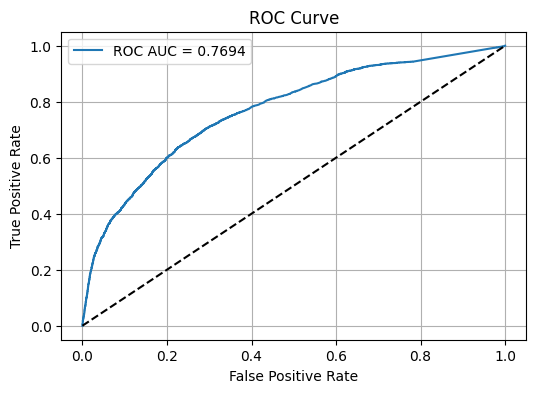

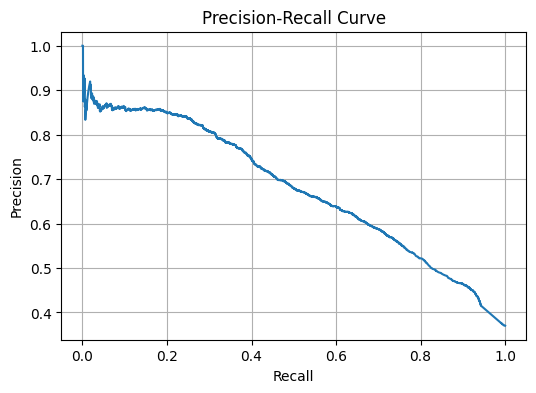

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score, roc_curve,
    precision_recall_curve
)

# 📊 Evaluation on test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()
all_labels = np.array(all_labels).flatten()

# ✅ Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Accuracy: {acc:.4f}")

# ✅ Classification Report
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("✅ Confusion Matrix:\n", cm)

# ✅ ROC AUC
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"✅ ROC AUC Score: {roc_auc:.4f}")

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()